# VWAP with Tick Data v1.5

## Parameters
Parameters: &lt;side&gt; &lt;quantity&gt; [limit_px]  
side = "b" (buy) or "s" (sell)  
quantity = # of shares  
limit_px = limit price (optional)  
tolerance = shares behind we are willing to get

In [19]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
import pandas as pd
import time
import datetime

matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

In [2]:
vwap_coefs = [ 7.49930092e-03, -5.05137528e-05,  2.26416619e-07, -5.19862243e-10, 4.79918459e-13 ]

# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size, coefs ):
    bar_num = np.arange( 0, 391 )
    bar_pcts = ( coefs[ 0 ] * bar_num + 
                coefs[ 1 ] * bar_num ** 2 + 
                coefs[ 2 ] * bar_num ** 3 + 
                coefs[ 3 ] * bar_num ** 4 + 
                coefs[ 4 ] * bar_num ** 5 )
    bar_pcts = bar_pcts / ( coefs[ 0 ] * 390 + 
                coefs[ 1 ] * 390 ** 2 + 
                coefs[ 2 ] * 390 ** 3 + 
                coefs[ 3 ] * 390 ** 4 + 
                coefs[ 4 ] * 390 ** 5 )
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( int ), order_size )

### Set up our market data

In [5]:
# load our taq file
taq = pd.read_pickle( 'TWTR_taq_20190131.gz' )

# get all the trades for later too
market_trades = pd.read_pickle ( 'TWTR_trades_201901.gz' )
market_trades = market_trades[ '2019-01-31' ]
market_trades = market_trades.between_time('09:30:00', '16:00:00')

# set order parameters
order_side = "b"
order_quantity = 250000

In [6]:
# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_vwap_targets( order_quantity, vwap_coefs )

In [7]:
# check our data
taq.head()

,EX_x,bid_price,bid_qty,ask_price,ask_qty,QU_COND,NATBBO_IND,QU_CANCEL,EX_y,TR_SCOND,trade_qty,trade_price,TR_SOURCE
2019-01-31 09:30:00.056871693,Z,32.96,17.0,33.18,2.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 09:30:00.057456000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T,100.0,33.08,C
2019-01-31 09:30:00.057496000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T,T,400.0,33.07,C
2019-01-31 09:30:00.057883273,B,31.33,1.0,35.24,1.0,R,A,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 09:30:00.058768165,P,33.05,1.0,33.15,1.0,R,G,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
len(taq)

2104802

### VWAP Simulation

In [60]:
# initialize some other variables
current_bar = 1
current_target = 0
quantity_filled = 0
quantity_remaining = order_quantity - quantity_filled
bid_price = 0.0
bid_quantity = 0.0
offer_price = 0.0
offer_quantity = 0.0
last_price = 0.0
last_quantity = 0.0
total_volume = 0.0
vwap_numerator = 0.0
trades_arr = []
passive_order_live = False
passive_order_price = 0
passive_order_quantity = 0
tolerance_threshold = 2500
avg_spread = 0.05

# main event loop
show_time( 'start loop' )
for index, row in taq.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = 9, minutes = 30 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    # determine message type
    if ( pd.isnull( row[ 'trade_qty' ] ) ): # it's a quote
        # collect BBO
        bid_price = row[ 'bid_price' ]
        offer_price = row[ 'ask_price' ]
        
        # what's wrong with the lines below?
        bid_quantity = row[ 'bid_qty' ] * 100 
        offer_quantity = row[ 'ask_qty' ] * 100
    
    else: # it's a trade
        last_price = row[ 'trade_price' ]
        last_quantity = row[ 'trade_qty' ]
        
        # collect volume
        total_volume += last_quantity
        
        # collect rolling VWAP
        vwap_numerator += last_quantity * last_price
        
        # now check to see if we have an order open?
        if passive_order_live:
            # has our order been hit?
            if ( order_side == 'b' and last_price <= passive_order_price ) or ( order_side == 's' and last_price >= passive_order_price ):
                # we have a trade
                new_trade_quantity = min( last_quantity, passive_order_quantity )
                trades_arr.append( ( last_price, new_trade_quantity, current_bar, index ) )
                quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
                quantity_filled += new_trade_quantity  
                passive_order_live = False

    # are we in a new minute?
    if ( minutes_from_open > current_bar ):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
        #print ( str(current_bar) + ': ' + str( current_target ) )
        
    # trade logic
    # v1.5: are we behind the target by more than our threshold? If so, do a trade, just pay the spread
    quantity_behind = current_target - quantity_filled
    if ( quantity_behind > tolerance_threshold ): # we need to trade now
        
        # assume you can execute the full size across spread
        new_trade_quantity = quantity_behind
        if ( order_side == 'b' ):
            new_trade_price = offer_price
        else: 
            new_trade_price = bid_price
            
        # do we have a valid last trade price? if not, we should skip, because market data is bad. 
        if ( new_trade_price == 0 ) or ( offer_price - bid_price > 5 * avg_spread ):
            # something is wrong, wait for market data to update
            continue
        
        trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )
        
        # update quantity remaining
        quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
        quantity_filled += new_trade_quantity    
        
    else: # we should place a passive order (if we don't already have one out there), (unless we are less than 100 shares!)
        if ( passive_order_live == False ) and ( quantity_behind >= 100 ):
            passive_order_quantity = quantity_behind
            if ( order_side == 'b' ):
                passive_order_price = bid_price
            else:
                passive_order_price = offer_price
            passive_order_live = True
        
# looping done
show_time( 'end loop' )

start loop : 2019-04-19 23:56:03:985486
end loop : 2019-04-20 00:02:21:439253


In [61]:
# Now, let's look at some stats
#trades = trades.dropna()

trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )

In [62]:
day_vwap = vwap_numerator / total_volume
print( 'stock volume: ' + str( total_volume ) )
print( 'order shares traded: ' + str( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
print( 'average price: ' + str( avg_price ) )
print( 'day vwap: ' + str( day_vwap ) )
print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )

stock volume: 17413086.0
order shares traded: 249090.0
average price: 33.386433257055685
day vwap: 33.37724710915122
average trade size: 2767.6666666666665


In [63]:
trades_df[ 'accum_shares' ] = trades_df[ 'trade_qty' ].cumsum()

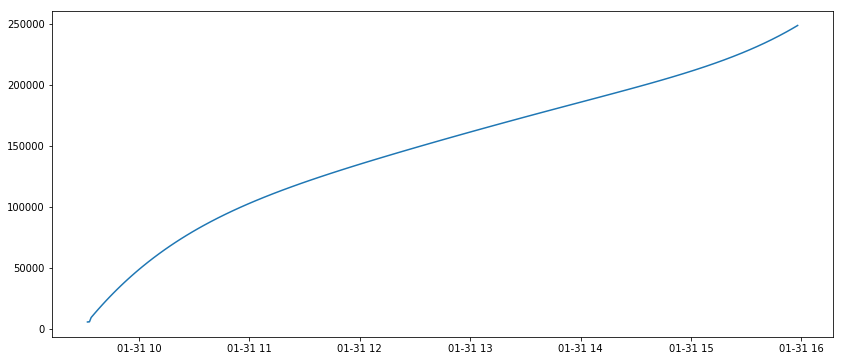

In [64]:
plt.plot( trades_df[ 'accum_shares' ] )

Text(0.5, 1.0, 'realized trade prices')

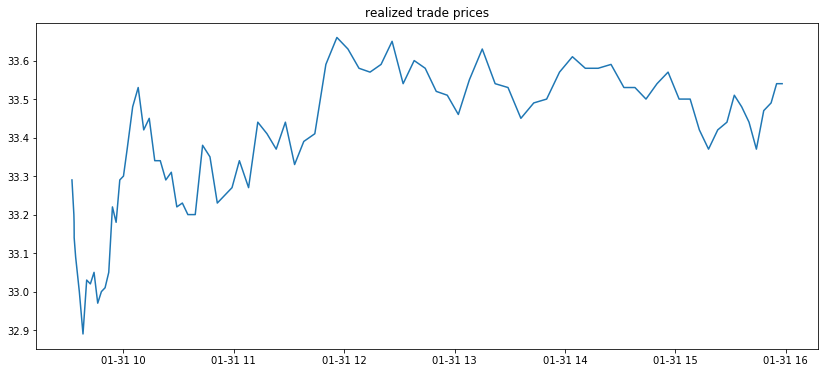

In [65]:
plt.plot( trades_df[ 'trade_price' ] )
plt.title( 'realized trade prices' )

In [66]:
trades_df[trades_df['trade_price'] == 0]

,trade_price,trade_qty,bar,accum_shares
time,,,,


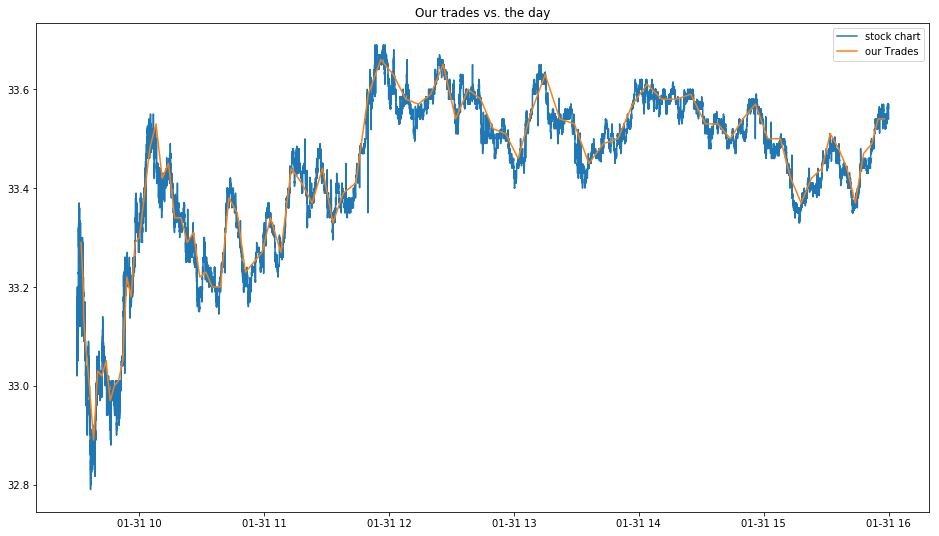

In [67]:
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )

ax1.plot( market_trades[ 'trade_price' ], label = 'stock chart' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()

In [26]:
len(trades_df)

15940